## Import Library 

In [67]:
import numpy as np #mengoperasikan array,vektor,matrix
import pandas as pd #memproses data
import matplotlib.pyplot as plt #visualisasi data
import seaborn as sns; sns.set() #menampilkan visualisasi grafik

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split #membagi data train, test
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from jcopml.utils import save_model, load_model

## Import Data

In [68]:
df = pd.read_csv("satpol.csv", error_bad_lines=False, sep=';')
df.head()

,tweet,sentimen
0,Tapi kayaknya itu satpol pp kota ****** sih ja...,negatif
1,"pak satpol PP kl puasanya ihklas dan bener"" se...",negatif
2,"b'Tak ada FPI, satpol pp pun jadi'",negatif
3,Satpol PP ngambil job desk fpi',negatif
4,Lah emang orang makan salahnya dimana? Satpol ...,negatif


In [69]:
df.shape

(128, 2)

Data terdiri dari 128 baris dan 2 kolom.

In [70]:
df.dtypes

tweet       object
sentimen    object
dtype: object

Tipe data telah sesuai.

In [71]:
df.isna().sum()

tweet       0
sentimen    0
dtype: int64

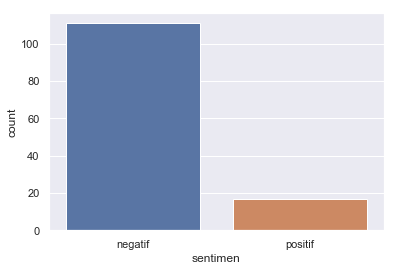

In [72]:
sns.countplot(df.sentimen);

In [73]:
df.sentimen.value_counts(normalize=True)

negatif    0.867188
positif    0.132812
Name: sentimen, dtype: float64

## Cleaning 

In [74]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sw_indo = stopwords.words('indonesian')

In [75]:
sw_indo.extend(['http','https'])

Idealnya kita definisikan sendiri stopwords kita tergantung masalah yang sedang dihadapi. Namun, kali ini saya hanya akan menggunakan stopwords indonesia bawaan nltk.

In [76]:
def cleansing(text):
    text = re.sub(r'^https?://.*[\r\n]*', '', text, flags=re.MULTILINE)
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1 and word.isalpha()]
    word_list = [word for word in word_list if word not in punctuation]
    word_list = [word for word in word_list if word not in sw_indo]
    text = ' '.join(word_list)
    return text

In [77]:
df['tweet'] = df.tweet.apply(cleansing)

In [78]:
df.head()

,tweet,sentimen
0,Tapi kayaknya satpol pp kota sih area suka ema...,negatif
1,satpol PP kl puasanya ihklas bener sesuai akid...,negatif
2,FPI satpol pp,negatif
3,Satpol PP ngambil job desk fpi,negatif
4,Lah emang orang makan salahnya dimana Satpol P...,negatif


## Dataset Splitting

In [79]:
X = df.tweet
y = df.sentimen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((102,), (26,), (102,), (26,))

In [80]:
X_test

15     Gara gara satpol pp grebek warung makan siang ...
124    Kalau nertibkan PKL yg menghalangi jalan OKAY ...
1      satpol PP kl puasanya ihklas bener sesuai akid...
99     fikriazy sasaran resto mall buka dibiarin gitu...
2                                          FPI satpol pp
46     males banget liat satpol pp nyita warung yg bu...
51     Buat yg nyalahin satpol pp kayaknya salah oran...
13                        Satpol PP mengayomi masyarakat
105    sih daerah yg melarang warung makanan buka pua...
87                                 Satpol PP cosplay FPI
23     Baru baca berita kalo warteg yg magicomnya dis...
72                                                PP tai
95     Aku skrg paham ormas dibubarin satpol pp peker...
120                       KompasTV Satpol PP penerus FPI
100              nacyxsi Gak tau gajelas emang satpol pp
83     Koramil Serma Erianto Anggota Polsek Satpol PP...
110    kasian liat satpol pp razia warung makan buka ...
33     ngeliat video satpol pp 

In [81]:
df_test = pd.DataFrame(X_test)
df_test

,tweet
15,Gara gara satpol pp grebek warung makan siang ...
124,Kalau nertibkan PKL yg menghalangi jalan OKAY ...
1,satpol PP kl puasanya ihklas bener sesuai akid...
99,fikriazy sasaran resto mall buka dibiarin gitu...
2,FPI satpol pp
46,males banget liat satpol pp nyita warung yg bu...
51,Buat yg nyalahin satpol pp kayaknya salah oran...
13,Satpol PP mengayomi masyarakat
105,sih daerah yg melarang warung makanan buka pua...
87,Satpol PP cosplay FPI


In [82]:
df_test.to_csv('test.csv')

## Modeling 

In [83]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
    ('algo', SVC(max_iter=500))
])


parameter = {'algo__gamma': np.logspace(-3, 3, 7),
             'algo__C': np.logspace(-3, 3, 7)}


model = GridSearchCV(pipeline, parameter, cv=5, n_jobs=-2, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done 103 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done 245 out of 245 | elapsed:    5.3s finished


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9901960784313726 0.9023809523809524 0.8846153846153846


## Evaluasi 

In [85]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix

In [86]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       0.99      1.00      0.99        88
     positif       1.00      0.93      0.96        14

    accuracy                           0.99       102
   macro avg       0.99      0.96      0.98       102
weighted avg       0.99      0.99      0.99       102


Test report
              precision    recall  f1-score   support

     negatif       0.88      1.00      0.94        23
     positif       0.00      0.00      0.00         3

    accuracy                           0.88        26
   macro avg       0.44      0.50      0.47        26
weighted avg       0.78      0.88      0.83        26



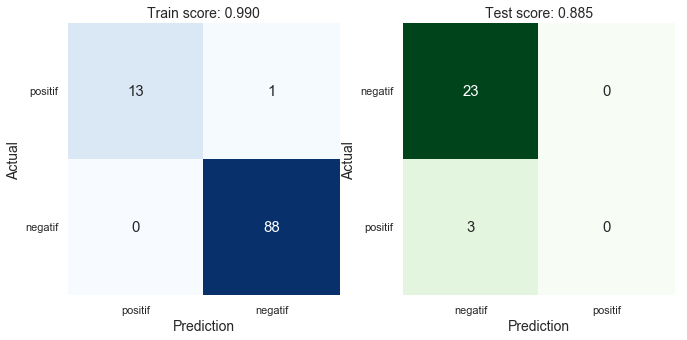

In [87]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Save Model 

In [88]:
save_model(model, "svm_satpolpp.pkl")

Model is pickled as model/svm_satpolpp.pkl


# Load Model

In [89]:
model_yg_diload= load_model("model/svm_satpolpp.pkl")

In [90]:
model_yg_diload.predict(X_test)

array(['negatif', 'negatif', 'negatif', 'negatif', 'negatif', 'negatif',
       'negatif', 'negatif', 'negatif', 'negatif', 'negatif', 'negatif',
       'negatif', 'negatif', 'negatif', 'negatif', 'negatif', 'negatif',
       'negatif', 'negatif', 'negatif', 'negatif', 'negatif', 'negatif',
       'negatif', 'negatif'], dtype=object)